In [1]:
%gui qt4
import pyface.qt

%matplotlib inline

In [2]:
import menpo3d.visualize
import numpy as np
import menpo.io as mio
import menpo3d.io as m3io
import itertools

# from menpo3d import correspond
from pathlib import Path
from menpo.model import PCAModel
from menpo.shape import PointCloud, TriMesh, ColouredTriMesh
from menpo.transform import AlignmentSimilarity, Translation
from menpo.visualize import print_progress

### Build High Res correspondence

In [3]:
ear_hres_db_path = Path('/vol/atlas/databases/ear/SymareDatabaseTenSubjects/Meshes/HighResolution/LeftEar/')

In [ ]:
aligned_ears = mio.import_pickle('/vol/atlas/databases/ear/3DMM_EAR/high_res_aligned_ears.pkl')

In [ ]:
centre = np.concatenate([ae.points for ae in aligned_ears]).mean(axis=0)
centring_trans = Translation(-centre)

pca_ear_3d = PCAModel([centring_trans.apply(ae) for ae in aligned_ears])

mean_ear_model = pca_ear_3d.mean()
# mean_ear_model.view()

### Build Low Res Correspondence

#### index generating

In [ ]:
[dense_ear, sparse_trilist, trilist, sparse_lms_index, dense_lms_index, matching_indexes] = mio.import_pickle('./global_variable.pkl')

#### dense projecting

In [ ]:
fullhead_db_path = Path('/vol/atlas/homes/yz4009/databases/FullHead/')
full_head_models = mio.import_pickles(fullhead_db_path)

In [ ]:
def dense_project(full_head, index, pca_ear_3d=pca_ear_3d, dense_ear=dense_ear, dense_lms_index=dense_lms_index, sparse_lms_index=sparse_lms_index, trilist=trilist, ):
    sparse_ear = TriMesh(full_head.points[matching_indexes], trilist=sparse_trilist)
    
    sparse_lms = TriMesh(sparse_ear.points[sparse_lms_index], trilist=trilist)
    dense_lms = TriMesh(dense_ear.points[dense_lms_index], trilist=trilist)

    transform_sparse = AlignmentSimilarity(
        sparse_lms, dense_lms
    )
    
#     sparse_aligned_landmark = correspond.non_rigid_icp(
#         dense_lms, transform_sparse.apply(sparse_lms)
#     )
    
    sparse_aligned_landmark = transform_sparse.apply(sparse_lms)

    components_index = np.concatenate([dense_lms_index[:,None], dense_lms_index[:,None] + 1 , dense_lms_index[:,None] + 2], axis=1).flatten()
    weights = np.dot(sparse_aligned_landmark.points.flatten()[None, :], pca_ear_3d.components.T[components_index])

    projection = pca_ear_3d.instance_vectors(weights, normalized_weights=True)
    projection = pca_ear_3d.template_instance.from_vector(projection)
    
    m3io.export_mesh(projection, '/vol/atlas/databases/ear/3DMM_EAR/dense_ears/%05d.obj'%index, overwrite=True)
    m3io.export_mesh(transform_sparse.apply(sparse_ear), '/vol/atlas/databases/ear/3DMM_EAR/dense_ears/%05d_sparse_aligned.obj'%index, overwrite=True)
    

### Build High Res Shape Model

In [ ]:
mesh_path = Path('/vol/atlas/databases/ear/3DMM_EAR/dense_ears')

In [ ]:
# aligned_ears = [m3io.import_mesh(p) for p in mesh_path.glob('*.obj') if not '_sparse_aligned' in p.as_posix()]
# mio.export_pickle(aligned_ears, '/vol/atlas/databases/ear/3DMM_EAR/high_res_aligned_ears_9k.pkl')

# aligned_ears = mio.import_pickle('/vol/atlas/databases/ear/3DMM_EAR/high_res_aligned_ears_9k.pkl')

# centre = np.concatenate([ae.points for ae in aligned_ears]).mean(axis=0)
# centring_trans = Translation(-centre)

# pca_ear_3d = PCAModel([centring_trans.apply(ae) for ae in aligned_ears])

pca_ear_3d = mio.import_pickle('/vol/atlas/databases/ear/3DMM_EAR/ear_shape_pca.pkl')
mean_ear_model = pca_ear_3d.mean()
# mean_ear_model.view()

In [ ]:
dense_lms = PointCloud(mean_ear_model.points[dense_lms_index])
# mean_ear_model.landmarks['PTS'] = dense_lms
# dense_lms.view()
mean_ear_model.view()

In [ ]:

pca_ear_3d.plot_eigenvalues_cumulative_ratio()

#### shading

In [ ]:
import sys
import math

In [ ]:
sys.path.append("/vol/phoebe/yz4009/gitdev/face2d3d/")

import shading
from menpo3d.rasterize import rasterize_mesh
from menpo3d.camera import PerspectiveCamera
from menpo.transform import Translation, UniformScale, Rotation, Homogeneous

In [ ]:
def rotation_matrix(angle, direction, point=None):
    sina = math.sin(angle)
    cosa = math.cos(angle)
    direction = np.array(direction).astype(np.float64)
    # rotation matrix around unit vector
    R = np.diag([cosa, cosa, cosa])
    R += np.outer(direction, direction) * (1.0 - cosa)
    direction *= sina
    R += np.array([[ 0.0,         -direction[2],  direction[1]],
                      [ direction[2], 0.0,          -direction[0]],
                      [-direction[1], direction[0],  0.0]])
    M = np.identity(4)
    M[:3, :3] = R
    if point is not None:
        # rotation not around origin
        point = np.array(point[:3], dtype=np.float64, copy=False)
        M[:3, 3] = point - np.dot(R, point)
    return M

In [ ]:
coloured_mean_ear_model = ColouredTriMesh(mean_ear_model.points, trilist=mean_ear_model.trilist)

# convert object to unit sphere
coloured_mean_ear_model = Translation(-coloured_mean_ear_model.centre_of_bounds()).apply(coloured_mean_ear_model)
radius = np.linalg.norm(reduce(lambda x,y: x-y, coloured_mean_ear_model.bounds())) / 2
coloured_mean_ear_model = UniformScale(1/radius, 3).apply(coloured_mean_ear_model)
# shading inside unit sphere
coloured_mean_ear_model = shading.lambertian_shading(coloured_mean_ear_model)

# project to image
coloured_mean_ear_model = Homogeneous(rotation_matrix(np.deg2rad(-90), [1,0,0])).apply(coloured_mean_ear_model)
coloured_mean_ear_model = Homogeneous(rotation_matrix(np.deg2rad(0), [0,1,0])).apply(coloured_mean_ear_model)
coloured_mean_ear_model = Homogeneous(rotation_matrix(np.deg2rad(90), [0,0,1])).apply(coloured_mean_ear_model)
coloured_mean_ear_model = UniformScale(128,3).apply(coloured_mean_ear_model)
coloured_mean_ear_model = Translation([128,128 ,0]).apply(coloured_mean_ear_model)

print coloured_mean_ear_model.bounds()

img =rasterize_mesh(coloured_mean_ear_model, [256, 256])

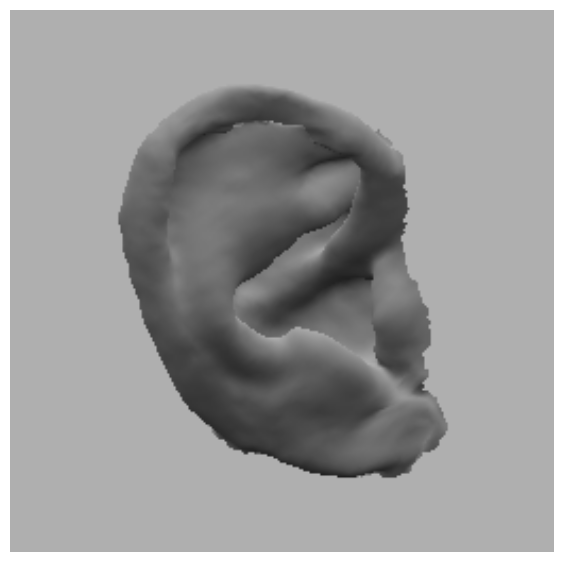

In [20]:
img.view()